# Load Packages and Data

In this notebook, I use injury data from the last 5 NBA seasons to do a survival analysis and compare how players recover from different types of injuries. The first steps of the notebook are to load in the relevant packages and data. I used Plotly to create the visuals for this analysis. 

In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import timedelta

warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

In [2]:
injury_df = pd.read_csv('injury_df.csv')
lastgames_df = pd.read_csv('last_games.csv')
injury_df.head()

Date      Team Acquired        Relinquished  \
0  2018-09-21    Pacers                • C.J. Wilcox   
1  2018-10-01   Thunder             • Andre Roberson   
2  2018-10-16     76ers             • Jerryd Bayless   
3  2018-10-16     76ers               • Mike Muscala   
4  2018-10-16     76ers            • Wilson Chandler   

                                               Notes  
0   placed on IL with torn right Achilles tendon ...  
1   placed on IL recovering from surgery on left ...  
2               placed on IL with sprained left knee  
3             placed on IL with sprained right ankle  
4          placed on IL with strained left hamstring

In [3]:
injury_df.shape

(9761, 5)

# Wrangling and Cleaning

The scraped data comes in a way that is difficult to immediately use as it gives one log for each time a player was "acquired" (taken off the injury list) and "relinquished" (put on the injury list). To make this easier to use, I turned the data into a dataframe of stints, where each stint has information on the player, date injured, date returned, and more information. This way, it is much easier to calculate injury lengths and compare how different injuries take time to heal. 

## Creating Injury Stints

In [4]:
# Split data into actions where player was put on injury list (relinquished) and where player was taken off list (acquired)
acq_df = injury_df[injury_df['Acquired'] != ' ']
rel_df = injury_df[injury_df['Relinquished'] != ' ']
print(acq_df.shape)
print(rel_df.shape)

(4621, 5)
(5139, 5)


In [5]:
# Delete bullet point and whitespace from player name
rel_df['Player'] = rel_df['Relinquished'].str[3:]
acq_df['Player'] = acq_df['Acquired'].str[3:]
rel_df.head()

Date      Team Acquired        Relinquished  \
0  2018-09-21    Pacers                • C.J. Wilcox   
1  2018-10-01   Thunder             • Andre Roberson   
2  2018-10-16     76ers             • Jerryd Bayless   
3  2018-10-16     76ers               • Mike Muscala   
4  2018-10-16     76ers            • Wilson Chandler   

                                               Notes           Player  
0   placed on IL with torn right Achilles tendon ...      C.J. Wilcox  
1   placed on IL recovering from surgery on left ...   Andre Roberson  
2               placed on IL with sprained left knee   Jerryd Bayless  
3             placed on IL with sprained right ankle     Mike Muscala  
4          placed on IL with strained left hamstring  Wilson Chandler

In [6]:
# Add an identifier for injuries where the player was out for the season
rel_df['OutSeason'] = (rel_df['Notes'].str.contains('out for season'))
rel_df.head(10)

Date        Team Acquired            Relinquished  \
0  2018-09-21      Pacers                    • C.J. Wilcox   
1  2018-10-01     Thunder                 • Andre Roberson   
2  2018-10-16       76ers                 • Jerryd Bayless   
3  2018-10-16       76ers                   • Mike Muscala   
4  2018-10-16       76ers                • Wilson Chandler   
5  2018-10-16       76ers                   • Zhaire Smith   
6  2018-10-16     Celtics            • Robert Williams III   
7  2018-10-16    Warriors               • DeMarcus Cousins   
8  2018-10-17       Bucks                    • D.J. Wilson   
9  2018-10-17   Cavaliers                • Larry Nance Jr.   

                                               Notes               Player  \
0   placed on IL with torn right Achilles tendon ...          C.J. Wilcox   
1   placed on IL recovering from surgery on left ...       Andre Roberson   
2               placed on IL with sprained left knee       Jerryd Bayless   
3             placed on IL with sprained right ankle         Mike Muscala   
4          placed on IL with strained left hamstring      Wilson Chandler   
5             placed on IL with surgery on left foot         Zhaire Smith   
6                                       placed on IL  Robert Williams III   
7   placed on IL with recovering from surgery to ...     DeMarcus Cousins   
8         placed on IL with strained right hamstring          D.J. Wilson   
9             placed on IL with sprained right ankle      Larry Nance Jr.   

   OutSeason  
0       True  
1       True  
2      False  
3      False  
4      False  
5      False  
6      False  
7      False  
8      False  
9      False

In [7]:
playerSet = set(rel_df['Player'].tolist() + acq_df['Player'].tolist())
len(playerSet)

749

In [8]:
# Find player names with errors, and put them into a list so we can remove them from the dataframe
nums = [str(i) for i in list(range(10))]
for p in playerSet:
    if p[0].islower():
        print(p)
    elif any(n in p for n in nums):
        print(p)
    elif 'NBA' in p:
        print(p)

left wrist injury (DTD)
76ers
Brandon Williams (b. 1975-02-27)
placed on IL with torn labrum in right hip
11/25/2019
placed on IL with surgery on right knee
sore calf (DTD)
Gerald Green (b. 1986-01-26)
placed on IL with left knee injury
placed on IL with sprained right thumb
placed on IL with right Achilles tendon injury
left knee injury (DTD)
placed on IL with bruised right hip
NBA health and safety protocols (DTD)
strained left quadriceps (DTD)


In [9]:
def isValid(name):
    if name[0].islower():
        return False
    if any(n in name for n in nums) and 'b.' not in name:
        return False
    if 'NBA' in name:
        return False
    return True

In [10]:
playerSet2 = set()
badList = []
for player in playerSet:
    if isValid(player):
        playerSet2.add(player)
    else:
        badList.append(player)
badList

['left wrist injury (DTD)',
 '76ers',
 'placed on IL with torn labrum in right hip',
 '11/25/2019',
 'placed on IL with surgery on right knee',
 'sore calf (DTD)',
 'placed on IL with left knee injury',
 'placed on IL with sprained right thumb',
 'placed on IL with right Achilles tendon injury',
 'left knee injury (DTD)',
 'placed on IL with bruised right hip',
 'NBA health and safety protocols (DTD)',
 'strained left quadriceps (DTD)']

In [11]:
playerSet = playerSet2.copy()

(array([ 70., 145., 172., 171., 137., 170.,  10.,   2.,   1.,   0.,   1.,
        136., 160., 189., 145.,  84.,   0.,   0.,   2., 120.,  15.,   1.,
          1., 103., 197., 142., 268., 203.,  23.,   6.,   0.,   0., 192.,
        326., 419., 191., 241., 123.,  12.,   0.,   0.,   0.,  60., 189.,
        182., 167., 168., 183.,  10.,   2.]),
 array([17795.  , 17829.86, 17864.72, 17899.58, 17934.44, 17969.3 ,
        18004.16, 18039.02, 18073.88, 18108.74, 18143.6 , 18178.46,
        18213.32, 18248.18, 18283.04, 18317.9 , 18352.76, 18387.62,
        18422.48, 18457.34, 18492.2 , 18527.06, 18561.92, 18596.78,
        18631.64, 18666.5 , 18701.36, 18736.22, 18771.08, 18805.94,
        18840.8 , 18875.66, 18910.52, 18945.38, 18980.24, 19015.1 ,
        19049.96, 19084.82, 19119.68, 19154.54, 19189.4 , 19224.26,
        19259.12, 19293.98, 19328.84, 19363.7 , 19398.56, 19433.42,
        19468.28, 19503.14, 19538.  ]),
 <BarContainer object of 50 artists>)

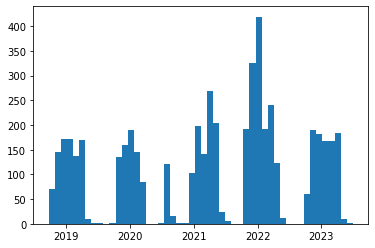

In [12]:
# Look at when injuries occur
# Notable that there is an obvious gap during what looks like offseason months, so data must not be collected during the 
# offseason
plt.hist(pd.to_datetime(rel_df['Date']), bins = 50)

In [13]:
# Add a start date for each season
seasonStartDates = {}
for yr in list(range(2019, 2025)):
    if yr == 2021:
        mth = '11'
    else:
        mth = '07'
    seasonStartDates[yr] = f"{yr-1}-{mth}-01"

seasonStartDates

{2019: '2018-07-01',
 2020: '2019-07-01',
 2021: '2020-11-01',
 2022: '2021-07-01',
 2023: '2022-07-01',
 2024: '2023-07-01'}

In [14]:
# Function to get the season of the injury from the date
def getSeason(date):
    for szn in range(2019, max(seasonStartDates.keys()) + 1):
        if date < seasonStartDates[szn]:
            return szn - 1

In [15]:
rel_df['season'] = rel_df['Date'].apply(getSeason)
rel_df.head()

Date      Team Acquired        Relinquished  \
0  2018-09-21    Pacers                • C.J. Wilcox   
1  2018-10-01   Thunder             • Andre Roberson   
2  2018-10-16     76ers             • Jerryd Bayless   
3  2018-10-16     76ers               • Mike Muscala   
4  2018-10-16     76ers            • Wilson Chandler   

                                               Notes           Player  \
0   placed on IL with torn right Achilles tendon ...      C.J. Wilcox   
1   placed on IL recovering from surgery on left ...   Andre Roberson   
2               placed on IL with sprained left knee   Jerryd Bayless   
3             placed on IL with sprained right ankle     Mike Muscala   
4          placed on IL with strained left hamstring  Wilson Chandler   

   OutSeason  season  
0       True    2019  
1       True    2019  
2      False    2019  
3      False    2019  
4      False    2019

In [16]:
acq_df['season'] = acq_df['Date'].apply(getSeason)
acq_df.head()

Date      Team                Acquired Relinquished  \
41  2018-10-19    Knicks           • Luke Kornet                
42  2018-10-19      Nets          • Allen Crabbe                
43  2018-10-19    Pacers         • Alize Johnson                
45  2018-10-19    Pacers           • C.J. Wilcox                
47  2018-10-20   Celtics   • Robert Williams III                

                 Notes               Player  season  
41   activated from IL          Luke Kornet    2019  
42   activated from IL         Allen Crabbe    2019  
43   activated from IL        Alize Johnson    2019  
45   activated from IL          C.J. Wilcox    2019  
47   activated from IL  Robert Williams III    2019

In [17]:
# Removes observations for players if a player has more than one season ending injury
def removeMutlSeasonEnd(rel_df):
    toRemove = []
    seasons = rel_df['season'].unique()
    for season in seasons:
        season_df = rel_df[rel_df['season'] == season]
        count_szn = season_df['OutSeason'].sum()
        if count_szn > 1:
            remove_df = season_df[season_df['OutSeason']].sort_values('Date')
            indexGone = remove_df.iloc[1:].index.tolist()
            toRemove = toRemove + indexGone
    return rel_df.drop(index = toRemove)

In [18]:
# gets the closest "acquired" row for each "relinquished" row so we can match up injury dates with return dates
def getClosestRow(acq_df, injured_date, season):
    after_df = acq_df[(acq_df['Date'] >= injured_date) & (acq_df['season'] == season)]
    if len(after_df) == 0:
        return None
    return after_df.iloc[0]

In [19]:
# get the last game for each season, add one day to get the censored return date for injuries without a return date
# (Will explain censoring further in a later section)
lastgames_df['Team'] = np.where(lastgames_df['Team'] == 'Trail Blazers', 'Blazers', lastgames_df['Team'])
lastgames_df['Season'] = pd.to_datetime(lastgames_df['Last Game']).dt.year
lastgame_dict = {}
endseason_dict = {}
for s in lastgames_df['Season'].unique():
    lastgame_dict[s] = {}
    season_df = lastgames_df[lastgames_df['Season'] == s]
    for _, row in season_df.iterrows():
        tm = row['Team']
        last_date = row['Last Game']
        lastgame_dict[s][tm] = str(pd.to_datetime(last_date) + pd.Timedelta(days = 1))[:10]
    maxDate = season_df['Last Game'].sort_values(ascending = False).iloc[0]
    maxDate = str(pd.to_datetime(maxDate) + pd.Timedelta(days = 1))[:10]
    endseason_dict[s] = maxDate

In [20]:
# Convert the injury data into stints for one player
def createStints(rel_df, acq_df):
    rel_df2 = removeMutlSeasonEnd(rel_df)
    
    dataDict = {}
    colnames = ['Date Injured', 'Date Return', 'Team', 'Player', 'Notes Injury', 'Notes Return', 'OutSeason', 'Season']
    for col in colnames:
        dataDict[col] = []
    
    rel_df2 = rel_df2.sort_values('Date')
    acq_df2 = acq_df.sort_values('Date')
    latestDate = "0000-00-00"
    for _, row in rel_df2.iterrows():
        if row['Date'] < latestDate:
            continue
        dataDict['Date Injured'].append(row['Date'])
        dataDict['Team'].append(row['Team'][1:])
        dataDict['Player'].append(row['Player'])
        dataDict['Notes Injury'].append(row['Notes'])
        dataDict['OutSeason'].append(row['OutSeason'])
        dataDict['Season'].append(row['season'])
        if row['OutSeason']:
            est_date = endseason_dict[row['season']]
            dataDict['Date Return'].append(est_date)
            dataDict['Notes Return'].append('Returned from season ending injury')
            latestDate = endseason_dict[row['season']]
        else:
            return_row = getClosestRow(acq_df2, row['Date'], row['season'])
            if return_row is None:
                est_date = lastgame_dict[row['season']][row['Team'][1:]]
                dataDict['Date Return'].append(est_date)
                # dataDict['Date Return'].append('Unknown')
                dataDict['Notes Return'].append('No Return Row')
            else:
                dataDict['Date Return'].append(return_row['Date'])
                dataDict['Notes Return'].append(return_row['Notes'])
                latestDate = return_row['Date']
                acq_df2 = acq_df2.drop(index = return_row.name)
    
    return pd.DataFrame(dataDict)

In [21]:
# Convert the injury data into stints for all players
def createAllStints(playerSet, rel_df, acq_df):
    df_list = []
    for player in playerSet:
        player_rel = rel_df[rel_df['Player'] == player]
        player_acq = acq_df[acq_df['Player'] == player]
        player_stints = createStints(player_rel, player_acq)
        df_list.append(player_stints)
    return pd.concat(df_list)

In [22]:
final_df = createAllStints(playerSet, rel_df, acq_df)
final_df

Date Injured Date Return          Team          Player  \
0    2018-10-01  2019-06-15       Thunder  Andre Roberson   
1    2019-10-23  2020-07-31       Thunder  Andre Roberson   
2    2020-08-09  2020-08-10       Thunder  Andre Roberson   
0    2018-10-16  2018-12-19         76ers  Jerryd Bayless   
1    2019-04-10  2019-06-15  Timberwolves  Jerryd Bayless   
..          ...         ...           ...             ...   
1    2021-04-11  2021-04-15     Cavaliers   Collin Sexton   
2    2021-04-24  2021-04-30     Cavaliers   Collin Sexton   
3    2021-11-19  2022-06-18     Cavaliers   Collin Sexton   
4    2022-12-08  2022-12-22          Jazz   Collin Sexton   
5    2023-02-22  2023-04-04          Jazz   Collin Sexton   

                                         Notes Injury  \
0    placed on IL recovering from surgery on left ...   
1                  placed on IL with left knee injury   
2                  placed on IL with sore right ankle   
0                placed on IL with sprained left knee   
1    placed on IL with right ankle injury (out for...   
..                                                ...   
1               placed on IL with strained left groin   
2                        placed on IL with concussion   
3    placed on IL recovering from surgery on left ...   
4          placed on IL with strained right hamstring   
5           placed on IL with strained left hamstring   

                          Notes Return  OutSeason  Season  
0   Returned from season ending injury       True    2019  
1                    activated from IL      False    2020  
2                    activated from IL      False    2020  
0                    activated from IL      False    2019  
1   Returned from season ending injury       True    2019  
..                                 ...        ...     ...  
1                    activated from IL      False    2021  
2                    activated from IL      False    2021  
3   Returned from season ending injury       True    2022  
4                    activated from IL      False    2023  
5                    activated from IL      False    2023  

[5037 rows x 8 columns]

In [23]:
final_df[final_df['Notes Return'] == 'No Return Row']

Date Injured Date Return     Team            Player  \
5    2019-01-10  2019-04-12    Kings   Skal Labissiere   
6    2020-01-01  2020-08-31  Blazers   Skal Labissiere   
7    2020-01-08  2020-08-31  Blazers   Skal Labissiere   
6    2019-02-05  2019-05-14    76ers      Shake Milton   
0    2022-12-03  2023-04-11  Blazers   John Butler Jr.   
..          ...         ...      ...               ...   
0    2022-12-12  2023-04-11   Pacers     Kendall Brown   
16   2023-04-04  2023-04-11     Jazz   Lauri Markkanen   
10   2023-03-03  2023-04-11  Pistons  Bojan Bogdanovic   
4    2021-01-17  2021-05-18  Raptors          Alex Len   
8    2023-03-28  2023-04-11    Spurs     Jeremy Sochan   

                                         Notes Injury   Notes Return  \
5                                        placed on IL  No Return Row   
6                                        placed on IL  No Return Row   
7                  placed on IL with left knee injury  No Return Row   
6                  placed on IL with fractured finger  No Return Row   
0                                        placed on IL  No Return Row   
..                                                ...            ...   
0                      placed on IL with tibia injury  No Return Row   
16                 placed on IL with left hand injury  No Return Row   
10                  placed on IL with Achilles injury  No Return Row   
4    placed on IL for NBA health and safety protocols  No Return Row   
8                   placed on IL with sore right knee  No Return Row   

    OutSeason  Season  
5       False    2019  
6       False    2020  
7       False    2020  
6       False    2019  
0       False    2023  
..        ...     ...  
0       False    2023  
16      False    2023  
10      False    2023  
4       False    2021  
8       False    2023  

[100 rows x 8 columns]

## Mark Observations with During COVID

I also made sure to mark which injury stints occurred during COVID. The observations during COVID are a little odd because there could have been a minor injury that occurred right before COVID happened, but the player may have not been taken off the injury list until about 4 months later because that is when the NBA resumed (in 2020, the NBA suspended play in mid-March and resumed mid-July). Therefore, I removed these observations because I feel like they don't give an accurate picture of how long it actually took a player to recover from their injury. 

In [24]:
final_df = final_df.sort_values('Date Injured')
final_df['id'] = list(range(len(final_df)))
final_df = final_df[['id'] + [col for col in final_df.columns if col != 'id']]
final_df

id Date Injured Date Return      Team               Player  \
0      0   2018-09-21  2019-06-15    Pacers          C.J. Wilcox   
0      1   2018-10-01  2019-06-15   Thunder       Andre Roberson   
0      2   2018-10-16  2018-11-03     76ers      Wilson Chandler   
0      3   2018-10-16  2019-01-18  Warriors     DeMarcus Cousins   
0      4   2018-10-16  2018-10-20   Celtics  Robert Williams III   
..   ...          ...         ...       ...                  ...   
2   5032   2023-05-06  2023-05-08      Heat        Udonis Haslem   
2   5033   2023-05-07  2023-05-12  Warriors  Patrick Baldwin Jr.   
4   5034   2023-05-08  2023-06-14    Knicks    Immanuel Quickley   
16  5035   2023-05-25  2023-05-27      Heat         Gabe Vincent   
29  5036   2023-05-27  2023-05-29   Celtics      Malcolm Brogdon   

                                         Notes Injury  \
0    placed on IL with torn right Achilles tendon ...   
0    placed on IL recovering from surgery on left ...   
0           placed on IL with strained left hamstring   
0    placed on IL with recovering from surgery to ...   
0                                        placed on IL   
..                                                ...   
2                   placed on IL with stomach illness   
2                        placed on IL with toe injury   
4    placed on IL with sprained left ankle (out fo...   
16              placed on IL with sprained left ankle   
29           placed on IL with strained right forearm   

                          Notes Return  OutSeason  Season  
0   Returned from season ending injury       True    2019  
0   Returned from season ending injury       True    2019  
0                    activated from IL      False    2019  
0                    activated from IL      False    2019  
0                    activated from IL      False    2019  
..                                 ...        ...     ...  
2                    activated from IL      False    2023  
2                    activated from IL      False    2023  
4   Returned from season ending injury       True    2023  
16                   activated from IL      False    2023  
29                   activated from IL      False    2023  

[5037 rows x 9 columns]

In [25]:
covidStart = '2020-03-12'
covidEnd = '2020-07-15'

isinCovid = (final_df['Date Injured'] < covidStart) & (final_df['Date Return'] > covidEnd)
is2020 = (final_df['Season'] == 2020)

covid_df = final_df[isinCovid & is2020]
covid_ids = set(covid_df['id'])

In [26]:
final_df['isCOVID'] = np.where(final_df['id'].isin(covid_ids), True, False)
final_df

id Date Injured Date Return      Team               Player  \
0      0   2018-09-21  2019-06-15    Pacers          C.J. Wilcox   
0      1   2018-10-01  2019-06-15   Thunder       Andre Roberson   
0      2   2018-10-16  2018-11-03     76ers      Wilson Chandler   
0      3   2018-10-16  2019-01-18  Warriors     DeMarcus Cousins   
0      4   2018-10-16  2018-10-20   Celtics  Robert Williams III   
..   ...          ...         ...       ...                  ...   
2   5032   2023-05-06  2023-05-08      Heat        Udonis Haslem   
2   5033   2023-05-07  2023-05-12  Warriors  Patrick Baldwin Jr.   
4   5034   2023-05-08  2023-06-14    Knicks    Immanuel Quickley   
16  5035   2023-05-25  2023-05-27      Heat         Gabe Vincent   
29  5036   2023-05-27  2023-05-29   Celtics      Malcolm Brogdon   

                                         Notes Injury  \
0    placed on IL with torn right Achilles tendon ...   
0    placed on IL recovering from surgery on left ...   
0           placed on IL with strained left hamstring   
0    placed on IL with recovering from surgery to ...   
0                                        placed on IL   
..                                                ...   
2                   placed on IL with stomach illness   
2                        placed on IL with toe injury   
4    placed on IL with sprained left ankle (out fo...   
16              placed on IL with sprained left ankle   
29           placed on IL with strained right forearm   

                          Notes Return  OutSeason  Season  isCOVID  
0   Returned from season ending injury       True    2019    False  
0   Returned from season ending injury       True    2019    False  
0                    activated from IL      False    2019    False  
0                    activated from IL      False    2019    False  
0                    activated from IL      False    2019    False  
..                                 ...        ...     ...      ...  
2                    activated from IL      False    2023    False  
2                    activated from IL      False    2023    False  
4   Returned from season ending injury       True    2023    False  
16                   activated from IL      False    2023    False  
29                   activated from IL      False    2023    False  

[5037 rows x 10 columns]

In [27]:
filt_df = final_df[(final_df['isCOVID'] == False)]
filt_df

id Date Injured Date Return      Team               Player  \
0      0   2018-09-21  2019-06-15    Pacers          C.J. Wilcox   
0      1   2018-10-01  2019-06-15   Thunder       Andre Roberson   
0      2   2018-10-16  2018-11-03     76ers      Wilson Chandler   
0      3   2018-10-16  2019-01-18  Warriors     DeMarcus Cousins   
0      4   2018-10-16  2018-10-20   Celtics  Robert Williams III   
..   ...          ...         ...       ...                  ...   
2   5032   2023-05-06  2023-05-08      Heat        Udonis Haslem   
2   5033   2023-05-07  2023-05-12  Warriors  Patrick Baldwin Jr.   
4   5034   2023-05-08  2023-06-14    Knicks    Immanuel Quickley   
16  5035   2023-05-25  2023-05-27      Heat         Gabe Vincent   
29  5036   2023-05-27  2023-05-29   Celtics      Malcolm Brogdon   

                                         Notes Injury  \
0    placed on IL with torn right Achilles tendon ...   
0    placed on IL recovering from surgery on left ...   
0           placed on IL with strained left hamstring   
0    placed on IL with recovering from surgery to ...   
0                                        placed on IL   
..                                                ...   
2                   placed on IL with stomach illness   
2                        placed on IL with toe injury   
4    placed on IL with sprained left ankle (out fo...   
16              placed on IL with sprained left ankle   
29           placed on IL with strained right forearm   

                          Notes Return  OutSeason  Season  isCOVID  
0   Returned from season ending injury       True    2019    False  
0   Returned from season ending injury       True    2019    False  
0                    activated from IL      False    2019    False  
0                    activated from IL      False    2019    False  
0                    activated from IL      False    2019    False  
..                                 ...        ...     ...      ...  
2                    activated from IL      False    2023    False  
2                    activated from IL      False    2023    False  
4   Returned from season ending injury       True    2023    False  
16                   activated from IL      False    2023    False  
29                   activated from IL      False    2023    False  

[4962 rows x 10 columns]

## Categorize Injuries

In this step, I uesd the injury notes given in the data to try to get an idea of what type of injury the player had. I tried to look at elements like the body part and severeness of the injury, along with the side of the body (if relevant) and if there was surgery involved. Some of the injury descriptions did not have any detail (some observations just say "placed on IL"), but there were many observations that provide relevant details. This is helpful because later I compare different types of injury recovery times using survival curves. 

In [28]:
def getSide(injury):
    if 'right' in injury:
        return 'Right'
    if 'left' in injury:
        return 'Left'
    return 'Unspecified'

def isSurgery(injury):
    if 'surgery' in injury and 'recover' not in injury:
        return True
    return False

def severeness(injury):
    injury = injury.replace('fractured', 'fracture')
    if 'recover' in injury and 'surgery' in injury:
        return 'Recovering From Surgery'
    sevOptions = ['surgery', 'sore', 'bruised', 'torn', 'sprained', 'strained', 'fracture', 'tightness', 
                  'inflammation']
    for sev in sevOptions:
        if sev in injury:
            return sev.title()
    return 'Unspecified'

def injuryCategory(injury):
    bodyOptions = ['knee', 'foot', 'ankle', 'shoulder', 'hip', 'lower back', 'back', 'toe', 'wrist',
                   'hamstring', 'calf', 'Achilles', 'elbow', 'groin', 'thumb', 'finger', 'hand', 'concussion',
                   'quadricep', 'neck', 'leg', 'thigh', 'adductor', 'heel', 'oblique', 'thigh', 'eye',
                   'abdominal', 'shin', 'pectoral', 'flu', 'nose', 'rib', 'conditioning', 'tibia', 'glute', 'muscle',
                   'throat', 'arm', 'cervical', 'forearm', 'head', 'spine', 'personal reasons', 'tailbone', 'fibula',
                   'gastroenteritis', 'facial', 'dental', 'respiratory', 'jaw', 'tooth', 'chest', 'hernia', 'sinus']
    injury = injury.replace('quadriceps', 'quadricep')
    injury = injury.replace(' (out for season)', '')
    if injury == ' placed on IL':
        return 'Unspecified'
    if 'health and safety protocols' in injury or 'COVID' in injury:
        return 'Health and Safety'
    if 'illness' in injury:
        return 'Illness'
    for part in bodyOptions:
        if part in injury:
            return part.title()
    return 'Other'

In [29]:
filt_df['Category'] = filt_df['Notes Injury'].apply(injuryCategory)
filt_df['Severeness'] = filt_df['Notes Injury'].apply(severeness)
filt_df['Surgery'] = filt_df['Notes Injury'].apply(isSurgery)
filt_df['side'] = filt_df['Notes Injury'].apply(getSide)

In [30]:
filt_df.head()

id Date Injured Date Return      Team               Player  \
0   0   2018-09-21  2019-06-15    Pacers          C.J. Wilcox   
0   1   2018-10-01  2019-06-15   Thunder       Andre Roberson   
0   2   2018-10-16  2018-11-03     76ers      Wilson Chandler   
0   3   2018-10-16  2019-01-18  Warriors     DeMarcus Cousins   
0   4   2018-10-16  2018-10-20   Celtics  Robert Williams III   

                                        Notes Injury  \
0   placed on IL with torn right Achilles tendon ...   
0   placed on IL recovering from surgery on left ...   
0          placed on IL with strained left hamstring   
0   placed on IL with recovering from surgery to ...   
0                                       placed on IL   

                         Notes Return  OutSeason  Season  isCOVID  \
0  Returned from season ending injury       True    2019    False   
0  Returned from season ending injury       True    2019    False   
0                   activated from IL      False    2019    False   
0                   activated from IL      False    2019    False   
0                   activated from IL      False    2019    False   

      Category               Severeness  Surgery         side  
0     Achilles                     Torn    False        Right  
0         Knee  Recovering From Surgery    False         Left  
0    Hamstring                 Strained    False         Left  
0     Achilles  Recovering From Surgery    False         Left  
0  Unspecified              Unspecified    False  Unspecified

### Word Counts

In [31]:
options = filt_df

phraseCounts = {}
wordCounts = {}
for _, row in options.iterrows():
    string = row['Notes Injury']
    string = string[1:]
    removePhrases = ['placed on IL ', ' (out for season)', '(', ')', 'with ', ' injury', 'in ', 'on ', 
                     'from ', 'to ', 'for ']
    for phrase in removePhrases:
        string = string.replace(phrase, '')
        
    if string in phraseCounts:
        phraseCounts[string] += 1
    else:
        phraseCounts[string] = 1
    
    words = string.split(' ')
    for word in words:
        if word in wordCounts:
            wordCounts[word] += 1
        else:
            wordCounts[word] = 1

In [32]:
def dictToDF(countDict, colname):
    d = {colname : [], 'count' : []}
    for key, value in countDict.items():
        d[colname].append(key)
        d['count'].append(value)
    df = pd.DataFrame(d)
    df = df.sort_values('count', ascending = False)
    return df

In [33]:
word_df = dictToDF(wordCounts, 'Word')
word_df.head(25)

Word  count
1        right   1412
6         left   1373
27        sore    745
7         knee    701
18       ankle    619
17    sprained    611
14      placed    565
15          IL    564
159  protocols    520
157        and    519
158     safety    519
156     health    519
155        NBA    516
41     illness    349
12    strained    273
29        back    261
32     bruised    232
16        foot    213
13   hamstring    209
21         hip    181
28       lower    158
30        calf    144
43    shoulder    108
50       groin     96
35   fractured     83

## Calculate Injury Length

Now that we have the dates for the injury and the return, it is simple to calculate the injury length. It is just the number of days between the return and the injury. 

However, this is not accurate for some observations. The data for observations where the injury is categorized as a season ending injury are more difficult to really know about. For season-ending injuries, I just made a base assumption that the player returned a day after the final game of the NBA Playoffs. However, this is going to miscount for a lot of the season ending injuries since the players could have recovered at any time during the off-season, but its just impossible to know from the data given. The injuries that occur towards the end of the season that do not have a return date are a similar case, because we don't know when the player actually recovered. 

Luckily, many survival analysis studies have had problems where they couldn't measure subjects' true survival times as they were unable to be reached or perished from an unexpected event. These observations are called censored observations. They are censored because we know the minimum amount of time they survived for, but we don't know how long they actually survived. In this exercise of studying NBA injuries, we can treat season-ending injuries and injuries towards the end of the season where the player recovered during the off-season as censored. Also important is to note that instead analyzing survival time (or time until death) as in typical survival analysis studies, we are looking at injury time (or time until recovery). We can still use survival analysis as time until recovery is still looking at how much time it takes until some event occurs, which is all that is really necessary for survival analysis. 

In [34]:
filt_df['Date Injured'] = pd.to_datetime(filt_df['Date Injured'])
filt_df['Date Return'] = pd.to_datetime(filt_df['Date Return'])
filt_df['Injury Length'] = (filt_df['Date Return'] - filt_df['Date Injured']).dt.days
filt_df

id Date Injured Date Return      Team               Player  \
0      0   2018-09-21  2019-06-15    Pacers          C.J. Wilcox   
0      1   2018-10-01  2019-06-15   Thunder       Andre Roberson   
0      2   2018-10-16  2018-11-03     76ers      Wilson Chandler   
0      3   2018-10-16  2019-01-18  Warriors     DeMarcus Cousins   
0      4   2018-10-16  2018-10-20   Celtics  Robert Williams III   
..   ...          ...         ...       ...                  ...   
2   5032   2023-05-06  2023-05-08      Heat        Udonis Haslem   
2   5033   2023-05-07  2023-05-12  Warriors  Patrick Baldwin Jr.   
4   5034   2023-05-08  2023-06-14    Knicks    Immanuel Quickley   
16  5035   2023-05-25  2023-05-27      Heat         Gabe Vincent   
29  5036   2023-05-27  2023-05-29   Celtics      Malcolm Brogdon   

                                         Notes Injury  \
0    placed on IL with torn right Achilles tendon ...   
0    placed on IL recovering from surgery on left ...   
0           placed on IL with strained left hamstring   
0    placed on IL with recovering from surgery to ...   
0                                        placed on IL   
..                                                ...   
2                   placed on IL with stomach illness   
2                        placed on IL with toe injury   
4    placed on IL with sprained left ankle (out fo...   
16              placed on IL with sprained left ankle   
29           placed on IL with strained right forearm   

                          Notes Return  OutSeason  Season  isCOVID  \
0   Returned from season ending injury       True    2019    False   
0   Returned from season ending injury       True    2019    False   
0                    activated from IL      False    2019    False   
0                    activated from IL      False    2019    False   
0                    activated from IL      False    2019    False   
..                                 ...        ...     ...      ...   
2                    activated from IL      False    2023    False   
2                    activated from IL      False    2023    False   
4   Returned from season ending injury       True    2023    False   
16                   activated from IL      False    2023    False   
29                   activated from IL      False    2023    False   

       Category               Severeness  Surgery         side  Injury Length  
0      Achilles                     Torn    False        Right            267  
0          Knee  Recovering From Surgery    False         Left            257  
0     Hamstring                 Strained    False         Left             18  
0      Achilles  Recovering From Surgery    False         Left             94  
0   Unspecified              Unspecified    False  Unspecified              4  
..          ...                      ...      ...          ...            ...  
2       Illness              Unspecified    False  Unspecified              2  
2           Toe              Unspecified    False  Unspecified              5  
4         Ankle                 Sprained    False         Left             37  
16        Ankle                 Sprained    False         Left              2  
29          Arm                 Strained    False        Right              2  

[4962 rows x 15 columns]

In [35]:
# Censor season-ending injuries and observations without a specified return date
filt_df['Censored'] = np.where((filt_df['Notes Return'] == 'No Return Row') | (filt_df['OutSeason']),
                               True, False)
filt_df.head(5)

id Date Injured Date Return      Team               Player  \
0   0   2018-09-21  2019-06-15    Pacers          C.J. Wilcox   
0   1   2018-10-01  2019-06-15   Thunder       Andre Roberson   
0   2   2018-10-16  2018-11-03     76ers      Wilson Chandler   
0   3   2018-10-16  2019-01-18  Warriors     DeMarcus Cousins   
0   4   2018-10-16  2018-10-20   Celtics  Robert Williams III   

                                        Notes Injury  \
0   placed on IL with torn right Achilles tendon ...   
0   placed on IL recovering from surgery on left ...   
0          placed on IL with strained left hamstring   
0   placed on IL with recovering from surgery to ...   
0                                       placed on IL   

                         Notes Return  OutSeason  Season  isCOVID  \
0  Returned from season ending injury       True    2019    False   
0  Returned from season ending injury       True    2019    False   
0                   activated from IL      False    2019    False   
0                   activated from IL      False    2019    False   
0                   activated from IL      False    2019    False   

      Category               Severeness  Surgery         side  Injury Length  \
0     Achilles                     Torn    False        Right            267   
0         Knee  Recovering From Surgery    False         Left            257   
0    Hamstring                 Strained    False         Left             18   
0     Achilles  Recovering From Surgery    False         Left             94   
0  Unspecified              Unspecified    False  Unspecified              4   

   Censored  
0      True  
0      True  
0     False  
0     False  
0     False

# Analyze Injuries

This section just provides some functions to get a quick table format summary of some of the injuries, split by category or severeness. 

## By Category

In [36]:
def analyze(df, groupingVars, outputVar, aggVars = ['count', 'mean'], includeOutSeason = True, minimum = 20):
    df_copy = df.copy()
    if not includeOutSeason:
        df_copy = df_copy[df_copy['OutSeason'] == False]
    
    byVar = df_copy.groupby(groupingVars)[outputVar].agg(aggVars)
    byVar = byVar[byVar['count'] >= minimum]
    if 'mean' in set(byVar.columns):
        byVar = byVar.sort_values('mean', ascending = False)
    return byVar

In [37]:
analyze(filt_df, groupingVars = ['Category'], outputVar = 'OutSeason')

count      mean
Category                          
Elbow                 37  0.135135
Foot                 215  0.130233
Toe                   71  0.126761
Shoulder             107  0.121495
Achilles              75  0.120000
Wrist                 73  0.109589
Knee                 699  0.107296
Finger                41  0.097561
Calf                 142  0.084507
Quadricep             79  0.075949
Adductor              54  0.074074
Thumb                 55  0.072727
Ankle                621  0.070853
Other                 45  0.066667
Heel                  30  0.066667
Groin                 95  0.063158
Concussion            82  0.060976
Hand                  50  0.060000
Leg                   34  0.058824
Hamstring            208  0.057692
Back                 109  0.055046
Neck                  39  0.051282
Hip                  182  0.049451
Thigh                 47  0.042553
Lower Back           150  0.040000
Health and Safety    529  0.026465
Unspecified          571  0.012259
Illness              348  0.011494

In [38]:
analyze(filt_df, groupingVars = ['Category'], outputVar = 'Injury Length', aggVars = ['count', 'mean', 'std'],
        includeOutSeason = False)

count       mean        std
Category                                      
Hand                  47  19.617021  22.565415
Finger                37  17.864865  20.728620
Thumb                 51  17.078431  19.034540
Wrist                 65  16.107692  26.560146
Foot                 187  15.828877  24.284661
Adductor              50  14.920000  26.902576
Leg                   32  13.937500  22.743929
Shoulder              94  13.553191  14.879167
Knee                 624  12.610577  21.759534
Unspecified          564  12.517730  20.483361
Achilles              66  11.924242  22.930202
Calf                 130  11.515385  15.840403
Hamstring            196  11.045918  12.010804
Elbow                 32  10.968750  17.961400
Hip                  173  10.589595  19.182699
Ankle                577  10.566724  16.329170
Other                 42   9.666667  14.767576
Back                 103   9.436893  20.636760
Neck                  37   9.297297  14.747627
Groin                 89   9.247191  11.791061
Heel                  28   9.178571  11.248221
Health and Safety    515   9.100971   9.096195
Toe                   62   8.629032  15.435996
Concussion            77   7.402597  11.359276
Quadricep             73   7.000000   8.460693
Lower Back           144   6.569444   8.892248
Thigh                 45   6.200000   6.323118
Illness              344   4.979651  11.069204

In [39]:
analyze(filt_df,
        groupingVars = ['Category', 'Severeness'],
        outputVar = 'Injury Length',
        aggVars = ['count', 'mean', 'std'],
        includeOutSeason = False,
        minimum = 10).head(30)

count       mean        std
Category    Severeness                               
Hand        Fracture         17  37.705882  26.093018
Finger      Fracture         13  33.000000  25.768197
Knee        Sprained         40  23.400000  22.894182
Shoulder    Sprained         20  18.350000  16.955903
Ankle       Unspecified      49  17.938776  25.970663
Calf        Strained         51  17.549020  20.190407
Adductor    Strained         24  17.250000  31.869639
Wrist       Unspecified      10  16.900000  18.101258
Hamstring   Strained         80  16.350000  12.789533
Thumb       Unspecified      15  16.000000  18.039639
Shoulder    Unspecified      36  15.666667  15.829448
            Strained         10  15.500000  16.787892
Foot        Sprained         30  14.533333  22.140201
            Unspecified      70  14.428571  21.932420
Quadricep   Strained         13  13.692308  13.888752
Groin       Strained         28  13.285714  13.393910
Unspecified Unspecified     564  12.517730  20.483361
Achilles    Sore             21  12.380952  26.008607
Knee        Unspecified     205  12.360976  21.134639
Hip         Unspecified      95  12.263158  21.778972
Adductor    Unspecified      24  12.166667  22.264549
Thumb       Sprained         24  11.875000  19.029297
Back        Sore             28  11.821429  27.670085
Knee        Inflammation     11  11.545455  22.133069
Foot        Sore             67  11.074627  17.845561
Ankle       Sprained        397  10.795970  16.084254
Other       Unspecified      36  10.722222  15.712799
Heel        Unspecified      19   9.842105  12.361514
Leg         Unspecified      20   9.650000  19.296236
Hip         Strained         14   9.642857  13.887499

In [40]:
analyze(filt_df[filt_df['Category'] == 'Hand'], 
        groupingVars = ['Severeness'], 
        outputVar = 'Injury Length', 
        aggVars = ['count', 'mean', 'std'],
        includeOutSeason = False,
        minimum = 2)

count       mean        std
Severeness                              
Fracture        17  37.705882  26.093018
Sprained         4  19.500000  23.629078
Unspecified     20   7.150000   6.651276
Sore             5   5.200000   4.919350

In [41]:
analyze(filt_df[filt_df['Category'] == 'Achilles'], 
        groupingVars = ['Severeness'], 
        outputVar = 'OutSeason', 
        aggVars = ['count', 'sum', 'mean'],
        minimum = 5)

count  sum      mean
Severeness                       
Torn             6    6  1.000000
Unspecified     46    3  0.065217
Sore            21    0  0.000000

In [42]:
analyze(filt_df[filt_df['Category'] == 'Foot'], 
        groupingVars = ['Severeness'], 
        outputVar = 'OutSeason', 
        aggVars = ['count', 'sum', 'mean'],
        minimum = 5)

count  sum      mean
Severeness                       
Fracture        10    5  0.500000
Unspecified     83   13  0.156627
Sore            73    6  0.082192
Sprained        31    1  0.032258
Bruised          8    0  0.000000

In [43]:
def makeScatter(df, x, y, color = None, hoverlabel = None):
    fig = go.Figure()
    if color is None and hoverlabel is None:
        fig.add_trace(go.Scatter(
            x = df[x],
            y = df[y],
            hovertemplate = x + ": %{x}<br>" + y + ": %{y}",
            mode = 'markers',
            name = ''
        ))
    elif color is None and hoverlabel is not None:
        fig.add_trace(go.Scatter(
            x = df[x],
            y = df[y],
            customdata = df[hoverlabel],
            hovertemplate = x + ": %{x}<br>" + y + ": %{y}<br>" + hoverlabel + ": %{customdata}",
            mode = 'markers',
            name = ''
        ))
    elif color is not None and hoverlabel is None:
        for group in df[color].unique():
            small_df = df[df[color] == group]
            fig.add_trace(go.Scatter(
                x = small_df[x],
                y = small_df[y],
                hovertemplate = x + ": %{x}<br>" + y + ": %{y}" + color + ": " + group,
                mode = 'markers',
                name = group
            ))
    elif color is not None and hoverlabel is not None:
        for group in df[color].unique():
            small_df = df[df[color] == group]
            fig.add_trace(go.Scatter(
                x = small_df[x],
                y = small_df[y],
                customdata = small_df[hoverlabel],
                hovertemplate = x + ": %{x}<br>" + y + ": %{y}" + color + ": " + group + "<br>" + hoverlabel + ": %{customdata}",
                mode = 'markers',
                name = group
            ))
    fig.update_layout(height = 600, width = 600,
                      xaxis_title = x, yaxis_title = y)
    return fig


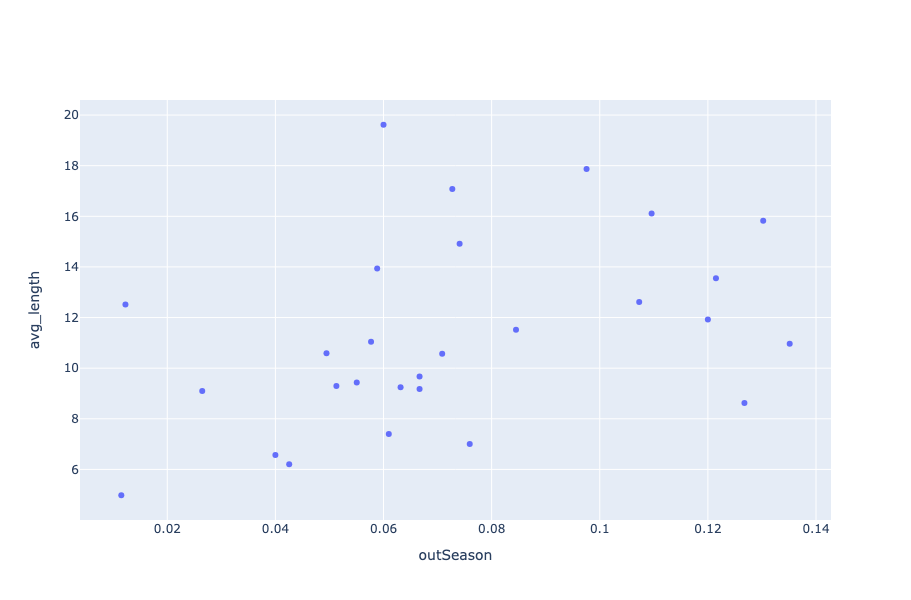

In [44]:
seasonByCat = analyze(filt_df, groupingVars = ['Category'], outputVar = 'OutSeason')
seasonByCat = seasonByCat.rename(columns = {'mean' : 'outSeason'})
lenByCat = analyze(filt_df, groupingVars = ['Category'], outputVar = 'Injury Length', 
                   includeOutSeason = False, minimum = 0)
lenByCat = lenByCat.rename(columns = {'count' : 'count2', 'mean' : 'avg_length'})
byCat = seasonByCat.merge(lenByCat, left_index = True, right_index = True, how = 'left')
byCat = byCat.reset_index()

makeScatter(byCat, x = 'outSeason', y = 'avg_length', hoverlabel = 'Category')

## By Severeness

In [45]:
analyze(filt_df, 
        groupingVars = ['Severeness'], 
        outputVar = 'OutSeason', 
        aggVars = ['count', 'mean'],
        minimum = 0)

count      mean
Severeness                              
Torn                        36  0.694444
Recovering From Surgery     26  0.384615
Surgery                     35  0.257143
Fracture                    85  0.188235
Inflammation                16  0.125000
Tightness                   41  0.097561
Strained                   273  0.087912
Sprained                   610  0.078689
Sore                       744  0.061828
Unspecified               2864  0.043994
Bruised                    232  0.038793

In [46]:
analyze(filt_df, 
        groupingVars = ['Severeness'], 
        outputVar = 'Injury Length', 
        aggVars = ['count', 'mean', 'std'],
        includeOutSeason = False,
        minimum = 0)

count       mean        std
Severeness                                          
Torn                        11  73.272727  45.675137
Surgery                     26  61.307692  44.209292
Recovering From Surgery     16  50.812500  38.110749
Fracture                    69  32.275362  24.302556
Strained                   249  15.244980  17.210750
Sprained                   562  12.181495  17.219744
Tightness                   37  10.162162  15.381290
Inflammation                14   9.928571  19.722944
Unspecified               2738   9.743608  16.145348
Sore                       698   8.253582  14.697920
Bruised                    223   6.506726   8.289726

In [47]:
analyze(filt_df[filt_df['Severeness'] == 'Torn'], 
        groupingVars = ['Category'], 
        outputVar = 'OutSeason', 
        aggVars = ['count', 'mean'],
        minimum = 0)

count      mean
Category                 
Achilles      6  1.000000
Adductor      1  1.000000
Foot          1  1.000000
Shoulder      2  1.000000
Knee         21  0.714286
Ankle         1  0.000000
Elbow         1  0.000000
Hip           1  0.000000
Oblique       1  0.000000
Pectoral      1  0.000000

In [48]:
analyze(filt_df[filt_df['Severeness'] == 'Torn'], 
        groupingVars = ['Category'], 
        outputVar = 'Injury Length', 
        aggVars = ['count', 'mean', 'std'],
        includeOutSeason = False,
        minimum = 0)

count        mean        std
Category                              
Pectoral      1  162.000000        NaN
Elbow         1   94.000000        NaN
Hip           1   87.000000        NaN
Knee          6   63.833333  43.092536
Ankle         1   53.000000        NaN
Oblique       1   27.000000        NaN

In [49]:
analyze(filt_df[filt_df['Severeness'] == 'Sore'], 
        groupingVars = ['Category'], 
        outputVar = 'Injury Length', 
        aggVars = ['count', 'mean', 'std'],
        includeOutSeason = False,
        minimum = 5)

count       mean        std
Category                               
Achilles       21  12.380952  26.008607
Back           28  11.821429  27.670085
Foot           67  11.074627  17.845561
Hip            30   9.033333  15.637010
Knee          277   8.971119  15.948260
Neck           11   8.090909  11.995454
Lower Back     69   6.231884   7.621843
Shoulder       22   5.500000   7.385636
Ankle         123   5.382114   5.667741
Hand            5   5.200000   4.919350
Heel            5   4.800000   4.438468
Elbow           6   4.500000   3.082207
Wrist          13   3.230769   2.420532

# Survival Curves

In this section, I actually use the now clean data to create survival curves and compare different types of injuries using visualizations including multiple survival curves overlayed on each other. In my function, I also give the option to return the area under the curves because I think this is a good tool to use to quantitatively compare two different survival curves. Survival curves with a greater area under the curve tend to be more dangerous injuries that take longer to recover from. 

In [50]:
filt_df.head()

id Date Injured Date Return      Team               Player  \
0   0   2018-09-21  2019-06-15    Pacers          C.J. Wilcox   
0   1   2018-10-01  2019-06-15   Thunder       Andre Roberson   
0   2   2018-10-16  2018-11-03     76ers      Wilson Chandler   
0   3   2018-10-16  2019-01-18  Warriors     DeMarcus Cousins   
0   4   2018-10-16  2018-10-20   Celtics  Robert Williams III   

                                        Notes Injury  \
0   placed on IL with torn right Achilles tendon ...   
0   placed on IL recovering from surgery on left ...   
0          placed on IL with strained left hamstring   
0   placed on IL with recovering from surgery to ...   
0                                       placed on IL   

                         Notes Return  OutSeason  Season  isCOVID  \
0  Returned from season ending injury       True    2019    False   
0  Returned from season ending injury       True    2019    False   
0                   activated from IL      False    2019    False   
0                   activated from IL      False    2019    False   
0                   activated from IL      False    2019    False   

      Category               Severeness  Surgery         side  Injury Length  \
0     Achilles                     Torn    False        Right            267   
0         Knee  Recovering From Surgery    False         Left            257   
0    Hamstring                 Strained    False         Left             18   
0     Achilles  Recovering From Surgery    False         Left             94   
0  Unspecified              Unspecified    False  Unspecified              4   

   Censored  
0      True  
0      True  
0     False  
0     False  
0     False

In [51]:
def getSurvivalData(df):
    values = sorted(df['Injury Length'].unique())
    atRisk = len(df)
    lastSurvival = 1
    censored_df = df[df['Censored']]
    normal_df = df[df['Censored'] == False]
    stats = {'Days' : values,
             'Number At Risk' : [],
             'Number Recovered' : [],
             'Number Censored' : [],
             'Survival Probability' : []}
    for v in values:
        numRec = len(normal_df[normal_df['Injury Length'] == v])
        numCen = len(censored_df[censored_df['Injury Length'] == v])
        stats['Number At Risk'].append(atRisk)
        stats['Number Recovered'].append(numRec)
        stats['Number Censored'].append(numCen)
        newLastSurvival = lastSurvival * (atRisk - numRec) / atRisk
        stats['Survival Probability'].append(newLastSurvival)
        lastSurvival = newLastSurvival
        atRisk = atRisk - numRec - numCen
    survival_df = pd.DataFrame(stats)
    return survival_df

def plotSurvivalCurve(df):
    survival_df = getSurvivalData(df)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x = survival_df['Days'],
        y = survival_df['Survival Probability'],
        mode = 'lines',
        line = dict(shape = 'hv'),
        customdata = np.round(100*survival_df['Survival Probability'],3),
        hovertemplate = "Time Since Injury: %{x} Days<br>Probability Still Injured: %{customdata}%",
        name = ''
    ))
    fig.update_layout(height = 600, width = 800,
                      xaxis_title = 'Days',
                      xaxis_range = [0,180],
                      yaxis_title = '% Players Still Injured',
                      yaxis_range = [0,1])
    return fig

def areaUnderCurve(survival_df):
    maxDay = 180
    days = survival_df['Days'].tolist()
    probs = survival_df['Survival Probability'].tolist()
    area = 0
    for i in range(len(days) - 1):
        if days[i + 1] > maxDay:
            change_d = 180 - days[i]
            p = probs[i]
            rect = change_d * p
            area += rect
            break
        change_d = days[i + 1] - days[i]
        p = probs[i]
        rect = change_d * p
        area += rect
    return area

def plotManySurvivalCurves(df, groupVar, minPerGroup = 10, areas = False, norm_area = True, colors = None):
    fig = go.Figure()
    aDict = {}
    for group in df[groupVar].unique():
        small_df = df[df[groupVar] == group]
        if len(small_df) < minPerGroup:
            continue
        survival_df = getSurvivalData(small_df)
        aDict[group] = areaUnderCurve(survival_df)
        if colors is None:
            fig.add_trace(go.Scatter(
                x = survival_df['Days'],
                y = survival_df['Survival Probability'],
                mode = 'lines',
                line = dict(shape = 'hv'),
                customdata = np.round(100*survival_df['Survival Probability'],1),
                hovertemplate = f"{groupVar}: {group}<br>" + "Time Since Injury: %{x} Days<br>Probability Still Injured: %{customdata}%",
                name = group
            ))
        else:
            fig.add_trace(go.Scatter(
                x = survival_df['Days'],
                y = survival_df['Survival Probability'],
                mode = 'lines',
                line = dict(shape = 'hv', color = colors[group]),
                customdata = np.round(100*survival_df['Survival Probability'],1),
                hovertemplate = f"{groupVar}: {group}<br>" + "Time Since Injury: %{x} Days<br>Probability Still Injured: %{customdata}%",
                name = group
            ))
    fig.update_layout(height = 600, width = 800,
                      xaxis_title = 'Days',
                      xaxis_range = [0,180],
                      yaxis_title = '% Players Still Injured',
                      yaxis_range = [0,1])
    if areas:
        if norm_area:
            baseline = areaUnderCurve(getSurvivalData(df))
            aDict = {k : v / baseline for k, v in aDict.items()}
        return fig, aDict
    return fig

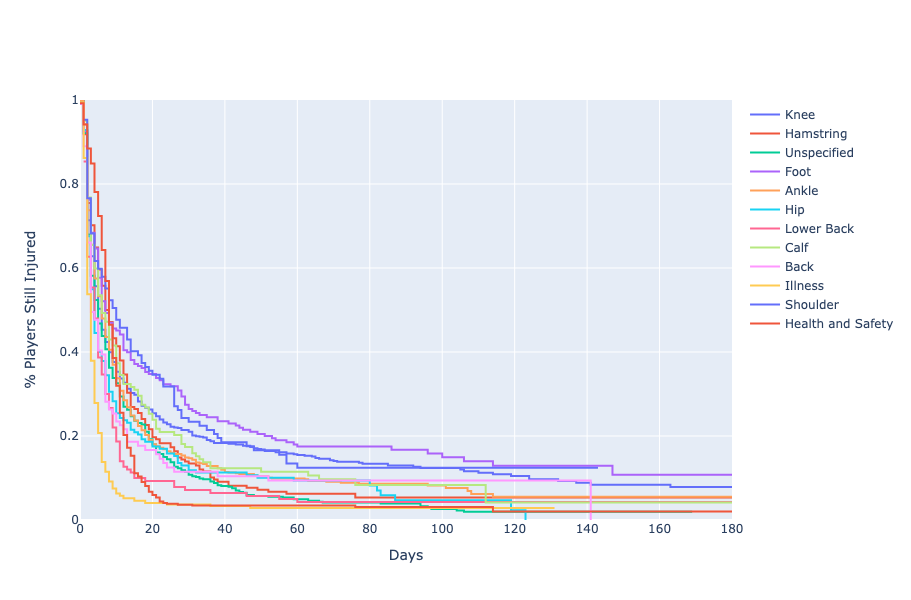

In [52]:
f, area = plotManySurvivalCurves(filt_df, 'Category', 100, areas = True)
f

In [53]:
sorted(area.items(), key = lambda x : -1*x[1])

[('Foot', 1.7315727083632135),
 ('Knee', 1.3888882288688948),
 ('Shoulder', 1.349202986559289),
 ('Ankle', 1.0273107202137726),
 ('Calf', 1.0191735350581577),
 ('Hamstring', 0.9570197564952145),
 ('Back', 0.8964627602648846),
 ('Hip', 0.714605962365131),
 ('Unspecified', 0.6941177596879979),
 ('Health and Safety', 0.626449059315402),
 ('Lower Back', 0.613205301275531),
 ('Illness', 0.3549443210820318)]

# Log Rank Test

Lastly, this section uses the log-rank test to see if there is a significant difference between the survival curves and injury recovery times for two different categories. 

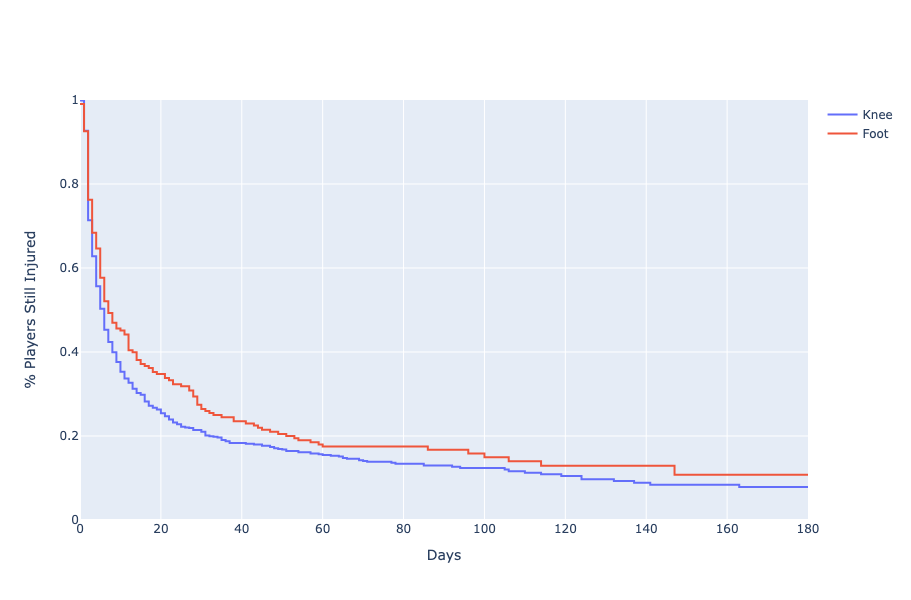

In [54]:
df1 = filt_df[filt_df['Category'] == 'Knee']
df2 = filt_df[filt_df['Category'] == 'Foot']
plotManySurvivalCurves(filt_df[filt_df['Category'].isin(['Knee', 'Foot'])], groupVar = 'Category')

In [55]:
from scipy import stats

def combineData(s1, s2):
    s1_days = set(s1['Days'])
    s2_days = set(s2['Days'])
    allDays = set(s1_days.union(s2_days))
    allDays = sorted(list(allDays))
    
    stats = {'Days' : allDays,
         'Number At Risk 1' : [],
         'Number At Risk 2' : [],
         'Number Events 1' : [],
         'Number Events 2' : []}
    for d in allDays:
        if d in s1_days:
            ar1 = s1[s1['Days'] == d]['Number At Risk'].iloc[0]
            ev1 = s1[s1['Days'] == d]['Number Recovered'].iloc[0]
            stats['Number At Risk 1'].append(ar1)
            stats['Number Events 1'].append(ev1)
        else:
            ar1 = s1[s1['Days'] <= d].sort_values('Days', ascending = False)
            if len(ar1) == 0:
                ar1 = s1.sort_values('Days')
            ar1 = ar1['Number At Risk'].iloc[0]
            stats['Number At Risk 1'].append(ar1)
            stats['Number Events 1'].append(0)

        if d in s2_days:
            ar2 = s2[s2['Days'] == d]['Number At Risk'].iloc[0]
            ev2 = s2[s2['Days'] == d]['Number Recovered'].iloc[0]
            stats['Number At Risk 2'].append(ar2)
            stats['Number Events 2'].append(ev2)
        else:
            ar2 = s2[s2['Days'] <= d].sort_values('Days', ascending = False)
            if len(ar2) == 0:
                ar2 = s2.sort_values('Days')
            ar2 = ar2['Number At Risk'].iloc[0]
            stats['Number At Risk 2'].append(ar2)
            stats['Number Events 2'].append(0)
    return pd.DataFrame(stats)

def logRankTest(df1, df2, pvalue = True):
    s1 = getSurvivalData(df1)
    s2 = getSurvivalData(df2)
    
    test_df = combineData(s1, s2)
    test_df['Total At Risk'] = test_df['Number At Risk 1'] + test_df['Number At Risk 2']
    test_df['Total Events'] = test_df['Number Events 1'] + test_df['Number Events 2']
    test_df['Expected Events 1'] = test_df['Number At Risk 1'] * test_df['Total Events'] / test_df['Total At Risk']
    test_df['Expected Events 2'] = test_df['Number At Risk 2'] * test_df['Total Events'] / test_df['Total At Risk']
    
    totalEvents1 = test_df['Number Events 1'].sum()
    totalEvents2 = test_df['Number Events 2'].sum()
    totalExpected1 = test_df['Expected Events 1'].sum()
    totalExpected2 = test_df['Expected Events 2'].sum()
    
    chi = ((totalEvents1 - totalExpected1)**2) / totalExpected1 + ((totalEvents2 - totalExpected2)**2) / totalExpected2
    if not pvalue:
        return chi
    pval = 1 - stats.chi2.cdf(chi, df = 1)
    return pval

In [56]:
logRankTest(filt_df[filt_df['Category'] == 'Knee'], filt_df[filt_df['Category'] == 'Foot'])

0.05249378263370308

## Log Rank Test for All Pairs of Injury Categories

In [57]:
cats = filt_df['Category'].value_counts() 
cats = cats[cats >= 50]
cats = cats.index.tolist()
len(cats)

21

In [58]:
compData = {'Category A' : [], 'Category B' : [], 'P-Value' : []}
count = 0
for i in range(len(cats)):
    for j in range(i + 1, len(cats)):
        compData['Category A'].append(cats[i])
        compData['Category B'].append(cats[j])
        pval = logRankTest(filt_df[filt_df['Category'] == cats[i]], filt_df[filt_df['Category'] == cats[j]])
        compData['P-Value'].append(pval)
compDF = pd.DataFrame(compData)
compDF.sort_values('P-Value')

Category A         Category B       P-Value
22               Ankle            Illness  0.000000e+00
3                 Knee            Illness  0.000000e+00
57   Health and Safety            Illness  0.000000e+00
74             Illness               Foot  0.000000e+00
75             Illness          Hamstring  1.029177e-13
..                 ...                ...           ...
115          Hamstring                Toe  9.631596e-01
175              Groin          Quadricep  9.639082e-01
201              Wrist              Thumb  9.667152e-01
39         Unspecified  Health and Safety  9.691200e-01
196           Achilles                Toe  9.752441e-01

[210 rows x 3 columns]

In [59]:
significant = compDF[compDF['P-Value'] <= 0.05/len(compDF)].sort_values('P-Value')
significant

Category A   Category B       P-Value
3                 Knee      Illness  0.000000e+00
22               Ankle      Illness  0.000000e+00
57   Health and Safety      Illness  0.000000e+00
74             Illness         Foot  0.000000e+00
75             Illness    Hamstring  1.029177e-13
40         Unspecified      Illness  6.398215e-13
80             Illness     Shoulder  1.691525e-11
78             Illness         Calf  2.132216e-10
89             Illness         Hand  7.053874e-08
41         Unspecified         Foot  1.221799e-07
85             Illness        Wrist  1.910715e-07
87             Illness        Thumb  2.670495e-07
58   Health and Safety         Foot  6.230681e-07
92                Foot   Lower Back  6.612655e-07
76             Illness          Hip  3.535810e-06
82             Illness   Concussion  4.301861e-06
88             Illness     Adductor  5.498196e-06
64   Health and Safety     Shoulder  1.009295e-05
1                 Knee  Unspecified  2.031661e-05
134         Lower Back     Shoulder  2.485774e-05
73   Health and Safety         Hand  2.950022e-05
7                 Knee   Lower Back  3.774564e-05
81             Illness        Groin  4.382527e-05
47         Unspecified     Shoulder  9.518348e-05
86             Illness          Toe  9.557717e-05
84             Illness     Achilles  1.355428e-04
91                Foot          Hip  1.468685e-04
83             Illness    Quadricep  1.825813e-04
79             Illness         Back  2.075833e-04

In [60]:
sigCounts = {}
for c in significant['Category A'].tolist():
    if c not in sigCounts:
        sigCounts[c] = 0
    sigCounts[c] += 1
for c in significant['Category B'].tolist():
    if c not in sigCounts:
        sigCounts[c] = 0
    sigCounts[c] += 1
sorted(sigCounts.items(), key = lambda x : -1*x[1])

[('Illness', 19),
 ('Foot', 5),
 ('Health and Safety', 4),
 ('Unspecified', 4),
 ('Shoulder', 4),
 ('Knee', 3),
 ('Lower Back', 3),
 ('Hand', 2),
 ('Hip', 2),
 ('Ankle', 1),
 ('Hamstring', 1),
 ('Calf', 1),
 ('Wrist', 1),
 ('Thumb', 1),
 ('Concussion', 1),
 ('Adductor', 1),
 ('Groin', 1),
 ('Toe', 1),
 ('Achilles', 1),
 ('Quadricep', 1),
 ('Back', 1)]

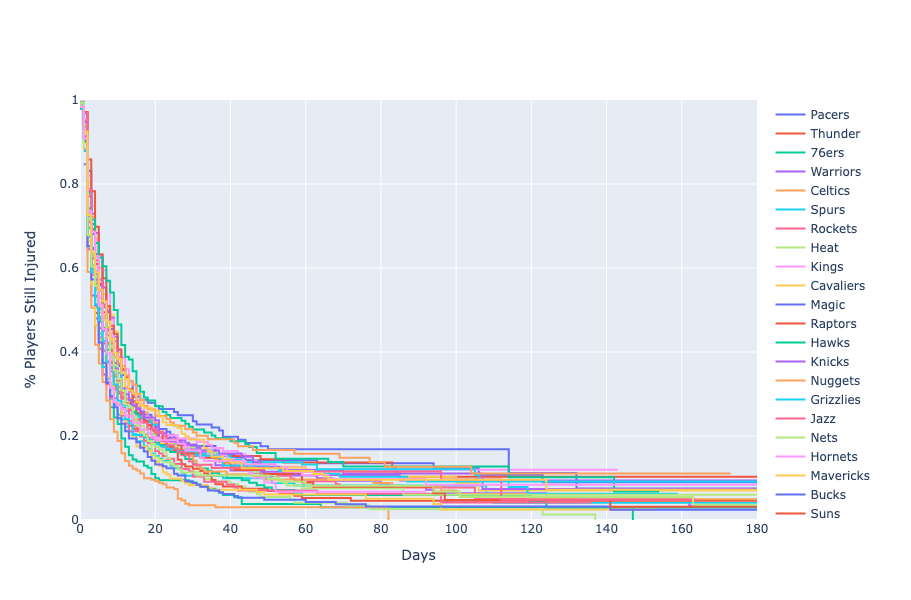

In [61]:
f, area = plotManySurvivalCurves(filt_df, groupVar = 'Team', areas = True)
f

In [62]:
sorted(area.items(), key = lambda x : -1*x[1])

[('Magic', 1.4838504517327074),
 ('Blazers', 1.4388079265614302),
 ('Bulls', 1.3564655739116114),
 ('Pacers', 1.3031343556889134),
 ('Wizards', 1.2555247041914108),
 ('Knicks', 1.2331467842526183),
 ('Thunder', 1.2308696866162459),
 ('Kings', 1.1994005432005896),
 ('Pistons', 1.171449327998215),
 ('Lakers', 1.169057621503663),
 ('Pelicans', 1.158035032336399),
 ('Cavaliers', 1.1550478249879697),
 ('Grizzlies', 1.080536153358258),
 ('Nets', 1.0203599389847275),
 ('Timberwolves', 1.012256458397396),
 ('Suns', 0.9703082622305769),
 ('Nuggets', 0.9592209890807252),
 ('Clippers', 0.9400732109126029),
 ('Warriors', 0.9300531259479042),
 ('Raptors', 0.8655973014289301),
 ('Spurs', 0.8228906983394062),
 ('Hornets', 0.8153338535593756),
 ('Hawks', 0.8149974206402918),
 ('Rockets', 0.7978863592566112),
 ('Jazz', 0.6958294752409759),
 ('Mavericks', 0.6041350036083635),
 ('Bucks', 0.601365204471703),
 ('Heat', 0.5971815601069264),
 ('76ers', 0.5724007844890623),
 ('Celtics', 0.3942426216745896)]

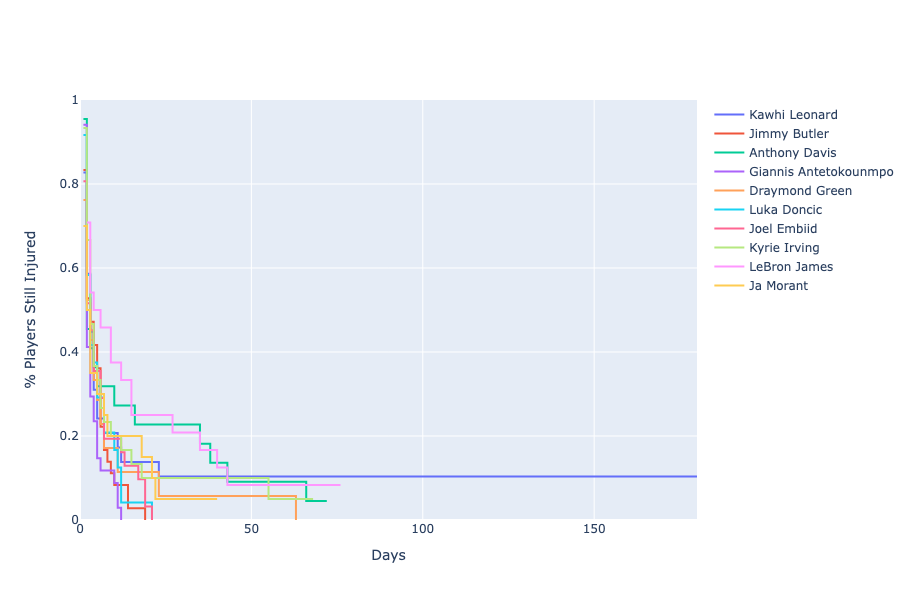

In [63]:
playerList = ['Jimmy Butler', 'Joel Embiid', 'Kyrie Irving', 'Giannis Antetokounmpo', 'Kawhi Leonard',
              'Anthony Davis', 'Luka Doncic', 'LeBron James', 'Ja Morant', 'Draymond Green']
f, area = plotManySurvivalCurves(filt_df[filt_df['Player'].isin(playerList)], groupVar = 'Player', areas = True)
f

In [64]:
sorted(area.items(), key = lambda x : -1*x[1])

[('Kawhi Leonard', 2.09902531895286),
 ('LeBron James', 1.4090679224452067),
 ('Anthony Davis', 1.3054763676725554),
 ('Kyrie Irving', 0.9165067878165348),
 ('Draymond Green', 0.6768193747562896),
 ('Ja Morant', 0.607737121332889),
 ('Joel Embiid', 0.4584905441897447),
 ('Luka Doncic', 0.40842548476672647),
 ('Jimmy Butler', 0.3648600997249424),
 ('Giannis Antetokounmpo', 0.25658730454756706)]

# Graphs

In [65]:
MAIN_COLOR = '#E4DBD7'
MY_COLOR = '#0d6890'
GRAY = '#C0C0C0'

def cleanFigure(fig, size = 700, grid = False):
    fig.update_layout(plot_bgcolor = MAIN_COLOR, paper_bgcolor = MAIN_COLOR,
                      height = size, width = size,
                      title_x = 0.5, title_xanchor = 'center', title_font_size = 20,
                      xaxis_gridcolor = GRAY, yaxis_gridcolor = GRAY,
                      xaxis_showgrid = grid, yaxis_showgrid = grid,
                      xaxis_linecolor = 'black', xaxis_linewidth = 1,
                      yaxis_linecolor = 'black', yaxis_linewidth = 1)
    f.update_yaxes(ticks = 'outside', tickcolor = MAIN_COLOR)
    f.update_xaxes(ticks = 'outside', tickcolor = MAIN_COLOR)

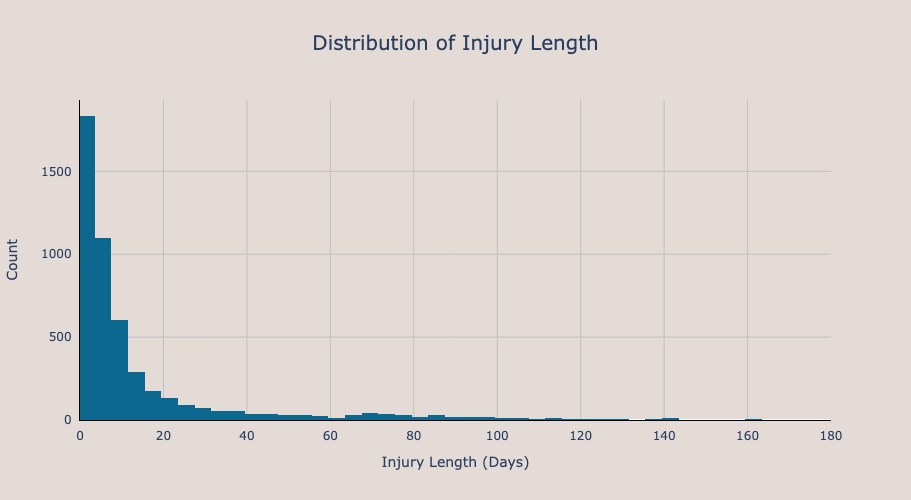

In [66]:
f = go.Figure()
f.add_trace(go.Histogram(
    x = filt_df['Injury Length'],
    xbins = go.histogram.XBins(size = 4),
    marker = dict(color = MY_COLOR, line_color = 'black')
))
f.update_layout(
    xaxis_range = [0,180],
    xaxis_title = 'Injury Length (Days)',
    yaxis_title = 'Count',
    title = dict(text = 'Distribution of Injury Length',
                 x = 0.5, xanchor = 'center',
                 font_size = 20)
)
cleanFigure(f, size = 500, grid = True)
# f.write_image('dist.png', scale = 5)
f

In [67]:
def barLayout(f, xlab, ylab, title):
    f.update_layout(
        yaxis = dict(title = ylab, linecolor = 'black'),
        xaxis = dict(title = xlab, linecolor = 'black'),
        title = dict(text = title,
                     x = 0.5, xanchor = 'center',
                     font_size = 20),
        yaxis_automargin = True
    )
    f.add_annotation(x = 0.4, xanchor = 'center', xref = 'paper',
                     y = 1.04, yanchor = 'bottom', yref = 'paper',
                     text = '2019-2023 Seasons | Showing Categories w/ >= 20 Injuries',
                     showarrow = False)
    cleanFigure(f)
    f.update_layout(xaxis_showgrid = True)

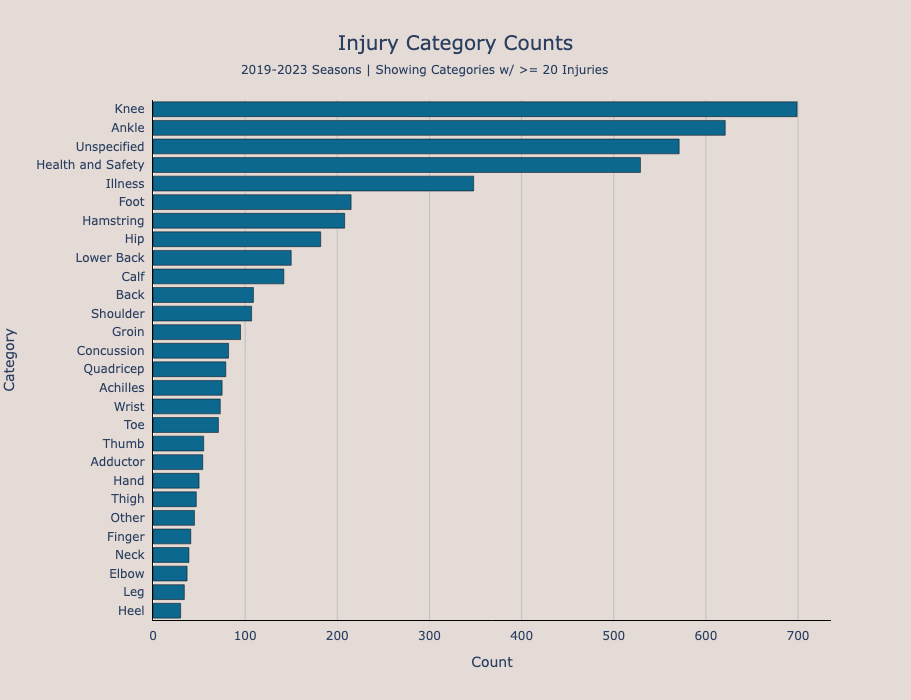

In [68]:
catCounts = filt_df['Category'].value_counts()
catCounts = catCounts[catCounts >= 20]
catCounts = catCounts.sort_values(ascending = True)
f = go.Figure()
f.add_trace(go.Bar(
    y = catCounts.index.tolist(),
    x = catCounts.values.tolist(),
    orientation = 'h',
    marker = dict(color = MY_COLOR, line_color = 'black')
))
barLayout(f, 'Count', 'Category', 'Injury Category Counts')
# f.write_image('counts.png', scale = 5)
f

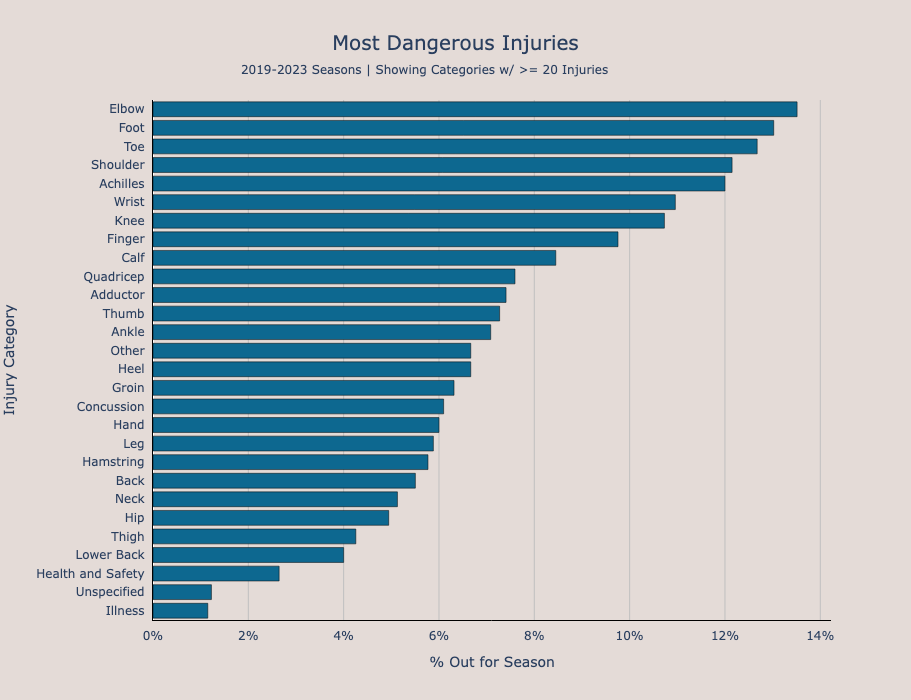

In [69]:
df = analyze(filt_df, groupingVars = ['Category'], outputVar = 'OutSeason')
df = df.sort_values('mean', ascending = True)
f = go.Figure()
f.add_trace(go.Bar(
    y = df.index.tolist(),
    x = df['mean'].tolist(),
    orientation = 'h',
    marker = dict(color = MY_COLOR, line_color = 'black')
))
barLayout(f, '% Out for Season', 'Injury Category', title = 'Most Dangerous Injuries')
f.update_layout(xaxis_tickformat = ',.0%')
# f.write_image('dangerous.png', scale = 5)
f

In [70]:
import random
random.seed(526)

categoryColors = {}
for c in filt_df['Category'].unique():
    col = f'rgb({random.randint(0,255)}, {random.randint(0,255)}, {random.randint(0,255)})'
    categoryColors[c] = col

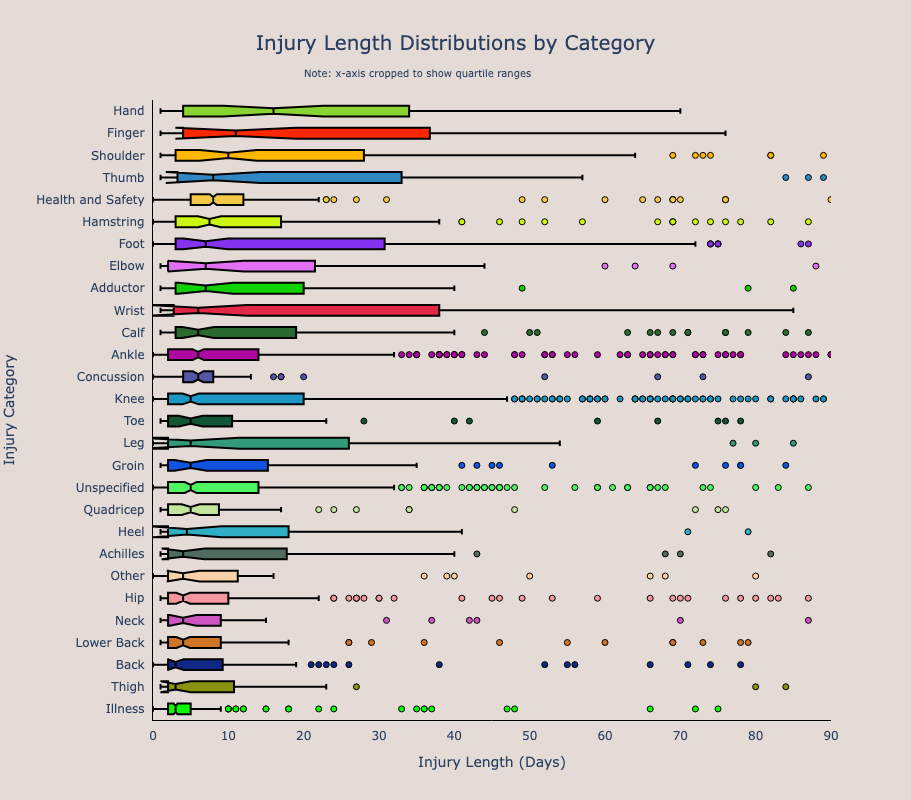

In [71]:
cats = filt_df.groupby('Category')['Injury Length'].agg(['count', 'mean', 'median'])
cats = cats[cats['count'] >= 20]
cats = cats.sort_values(['median', 'mean'], ascending = True)
f = go.Figure()
for c in cats.index:
    f.add_trace(go.Box(
        x = filt_df[filt_df['Category'] == c]['Injury Length'],
        name = c,
        notched = True,
        fillcolor = categoryColors[c],
        line_color = 'black',
        marker = dict(color = categoryColors[c], line_color = 'black', line_width = 1),
        showlegend = False
    ))
f.update_layout(xaxis_title = 'Injury Length (Days)',
                yaxis_title = 'Injury Category',
                title = dict(text = 'Injury Length Distributions by Category',
                             x = 0.5, xanchor = 'center'))
f.add_annotation(text = 'Note: x-axis cropped to show quartile ranges',
                 x = 0.22, xanchor = 'left', showarrow = False, xref = 'paper', yref = 'paper',
                 y = 1.03, yanchor = 'bottom', font_size = 10)
cleanFigure(f, size = 800)
f.update_layout(xaxis_range = [0,90])
# f.write_image('lengths.png', scale = 5)
f

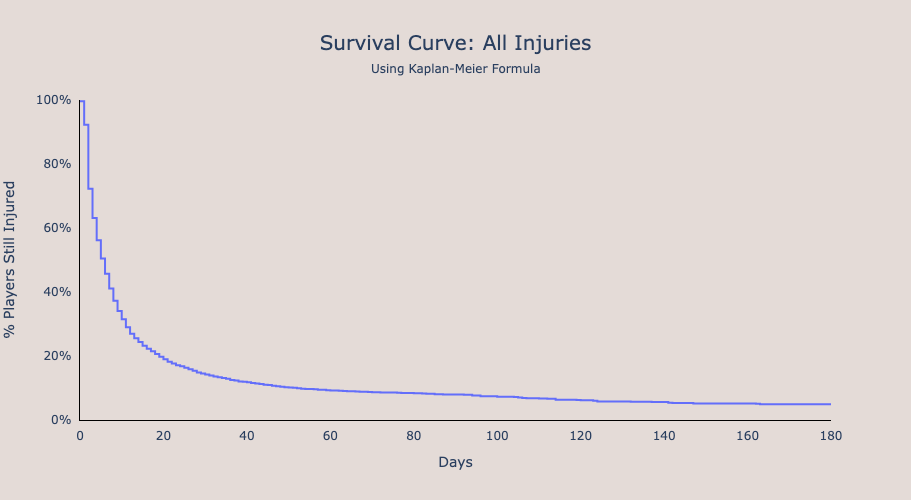

In [72]:
f = plotSurvivalCurve(filt_df)
f.update_layout(title_text = 'Survival Curve: All Injuries',
                yaxis_tickformat = ',.0%')
f.add_annotation(text = 'Using Kaplan-Meier Formula',
                 x = 0.5, xanchor = 'center', xref = 'paper',
                 y = 1.07, yanchor = 'bottom', yref = 'paper',
                 showarrow = False, font_size = 12)
cleanFigure(f, size = 500, grid = False)
# f.write_image('one_curve.png', scale = 5)
f

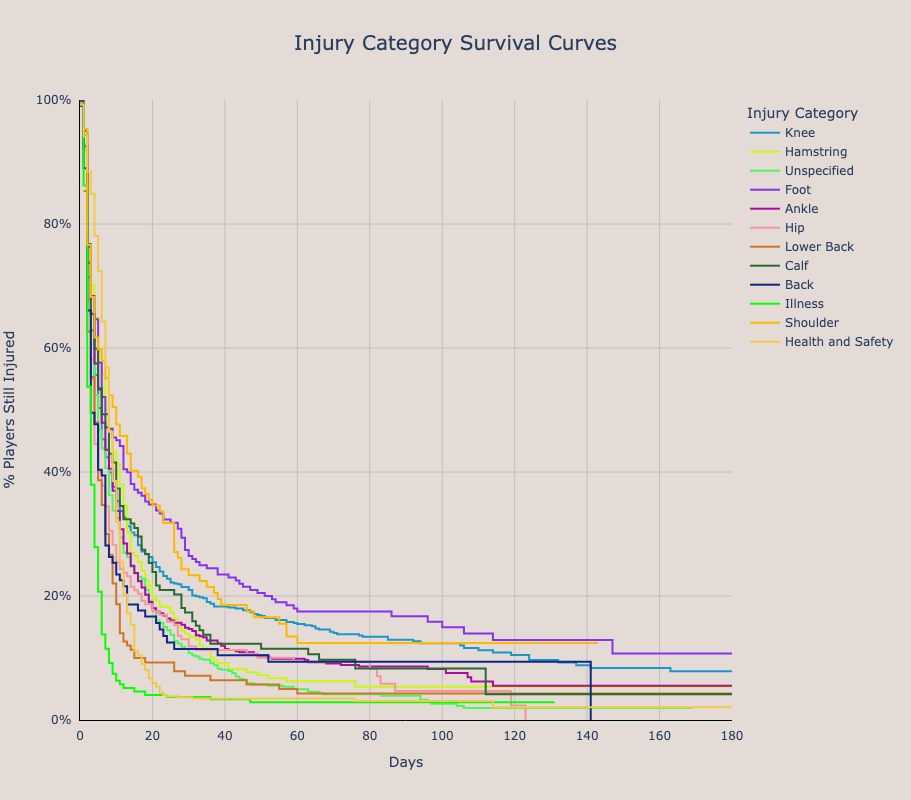

In [73]:
f, area = plotManySurvivalCurves(filt_df, groupVar = 'Category', minPerGroup = 100, areas = True, norm_area = True,
                                 colors = categoryColors)
f.update_layout(title_text = 'Injury Category Survival Curves',
                legend_title = 'Injury Category',
                yaxis_tickformat = ',.0%')
cleanFigure(f, size = 800, grid = True)
f.update_layout(width = 900)
# f.write_image('survival_curves.png', scale = 5)
f

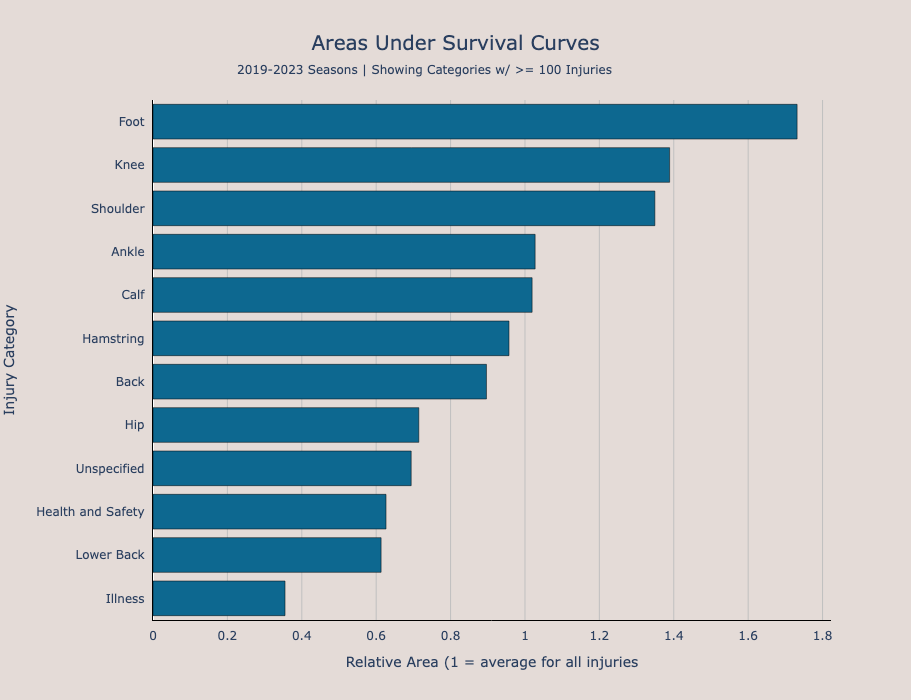

In [74]:
area2 = sorted(area.items(), key = lambda x : x[1])
f = go.Figure()
f.add_trace(go.Bar(
    y = [a for a, b in area2],
    x = [b for a, b in area2],
    orientation = 'h',
    marker = dict(color = MY_COLOR, line_color = 'black')
))
barLayout(f, xlab = 'Relative Area (1 = average for all injuries', ylab = 'Injury Category', 
          title = 'Areas Under Survival Curves')
f.update_annotations(text = '2019-2023 Seasons | Showing Categories w/ >= 100 Injuries')
# f.write_image('area.png', scale = 5)
f

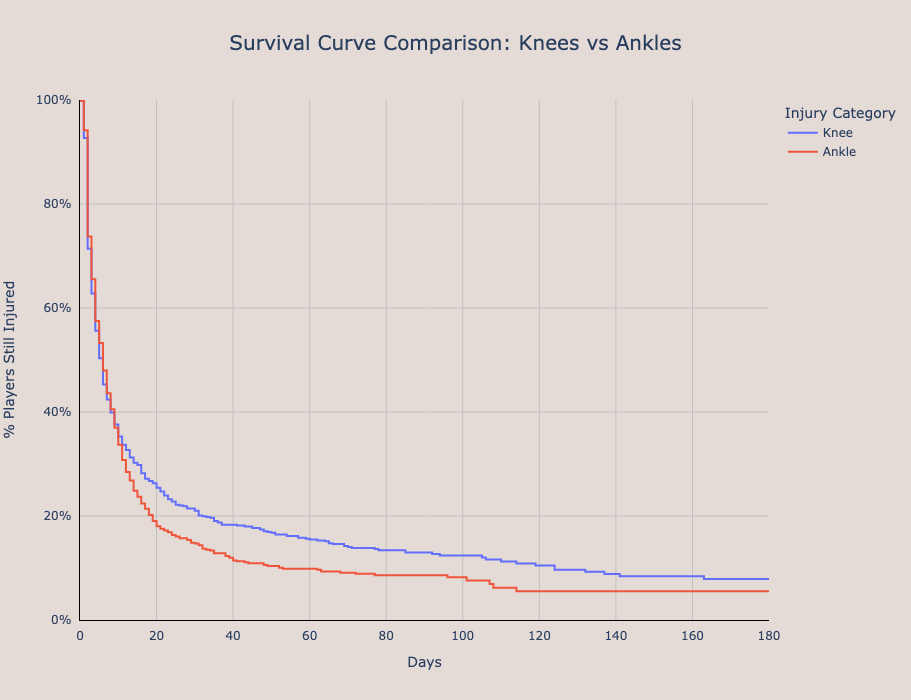

In [75]:
f = plotManySurvivalCurves(filt_df[filt_df['Category'].isin(['Knee', 'Ankle'])], 
                           groupVar = 'Category', minPerGroup = 100, areas = False)
f.update_layout(title_text = 'Survival Curve Comparison: Knees vs Ankles',
                legend_title = 'Injury Category',
                yaxis_tickformat = ',.0%')
cleanFigure(f, size = 700, grid = True)
# f.write_image('comp_curve.png', scale = 5)
f

In [76]:
logRankTest(filt_df[filt_df['Category'] == 'Knee'], filt_df[filt_df['Category'] == 'Ankle'])

0.0825751944508637